# Train on generated data

In [1]:
PATH = "../data"
FILE = "gen.csv"

In [91]:
import numpy as np
import pandas as pd
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import optimizers
from keras.utils.vis_utils import plot_model

from tensorflow.keras import Input
from tensorflow.keras import Model
from tcn import TCN

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

from utils import *

In [44]:
err_upper_limit = 14
n_epochs = 1300
pd.options.display.max_columns = 25

## Read the data

In [7]:
df = pd.read_csv(f'{PATH}/{FILE}')
df

,Day,AVG_WHP_P,BORE_GAS_VOL,BORE_WAT_VOL,BORE_OIL_VOL,AVG_WHT_P,DP_CHOKE_SIZE,AVG_CHOKE_SIZE_P,AVG_DOWNHOLE_PRESSURE,AVG_DOWNHOLE_TEMPERATURE
0,0,44.46529,181.651766,-4.133246,3.684399,9.433207,182.069000,0.000000,400.4861,83.60972
1,1,42.15982,194892.134400,938.123424,1341.367776,85.538250,0.193870,30.993760,179.1635,108.98720
2,2,42.17241,194242.060800,956.686464,1335.482208,86.004270,0.037466,52.996260,179.6670,109.29690
3,3,42.18486,193231.958400,973.704672,1327.113504,86.288940,0.037508,53.000000,180.4194,109.44930
4,4,42.19760,192194.812800,990.771264,1318.546080,86.516270,0.037543,53.000000,181.1870,109.55160
5,5,42.21059,191141.856000,1007.923392,1309.861152,86.713390,0.037576,53.000000,181.9656,109.62800
6,6,42.22380,190075.161600,1025.179200,1301.069952,86.891290,0.037607,53.000000,182.7535,109.68830
7,7,42.23722,188995.248000,1042.543872,1292.175072,87.056020,0.037634,53.000000,183.5500,109.73800
8,8,42.25086,187910.323200,1060.066656,1283.236128,87.209770,0.032886,54.999990,184.3483,109.77780
9,9,42.26474,186823.756800,1077.760512,1274.273856,87.356240,0.028758,56.999880,185.1567,109.81090


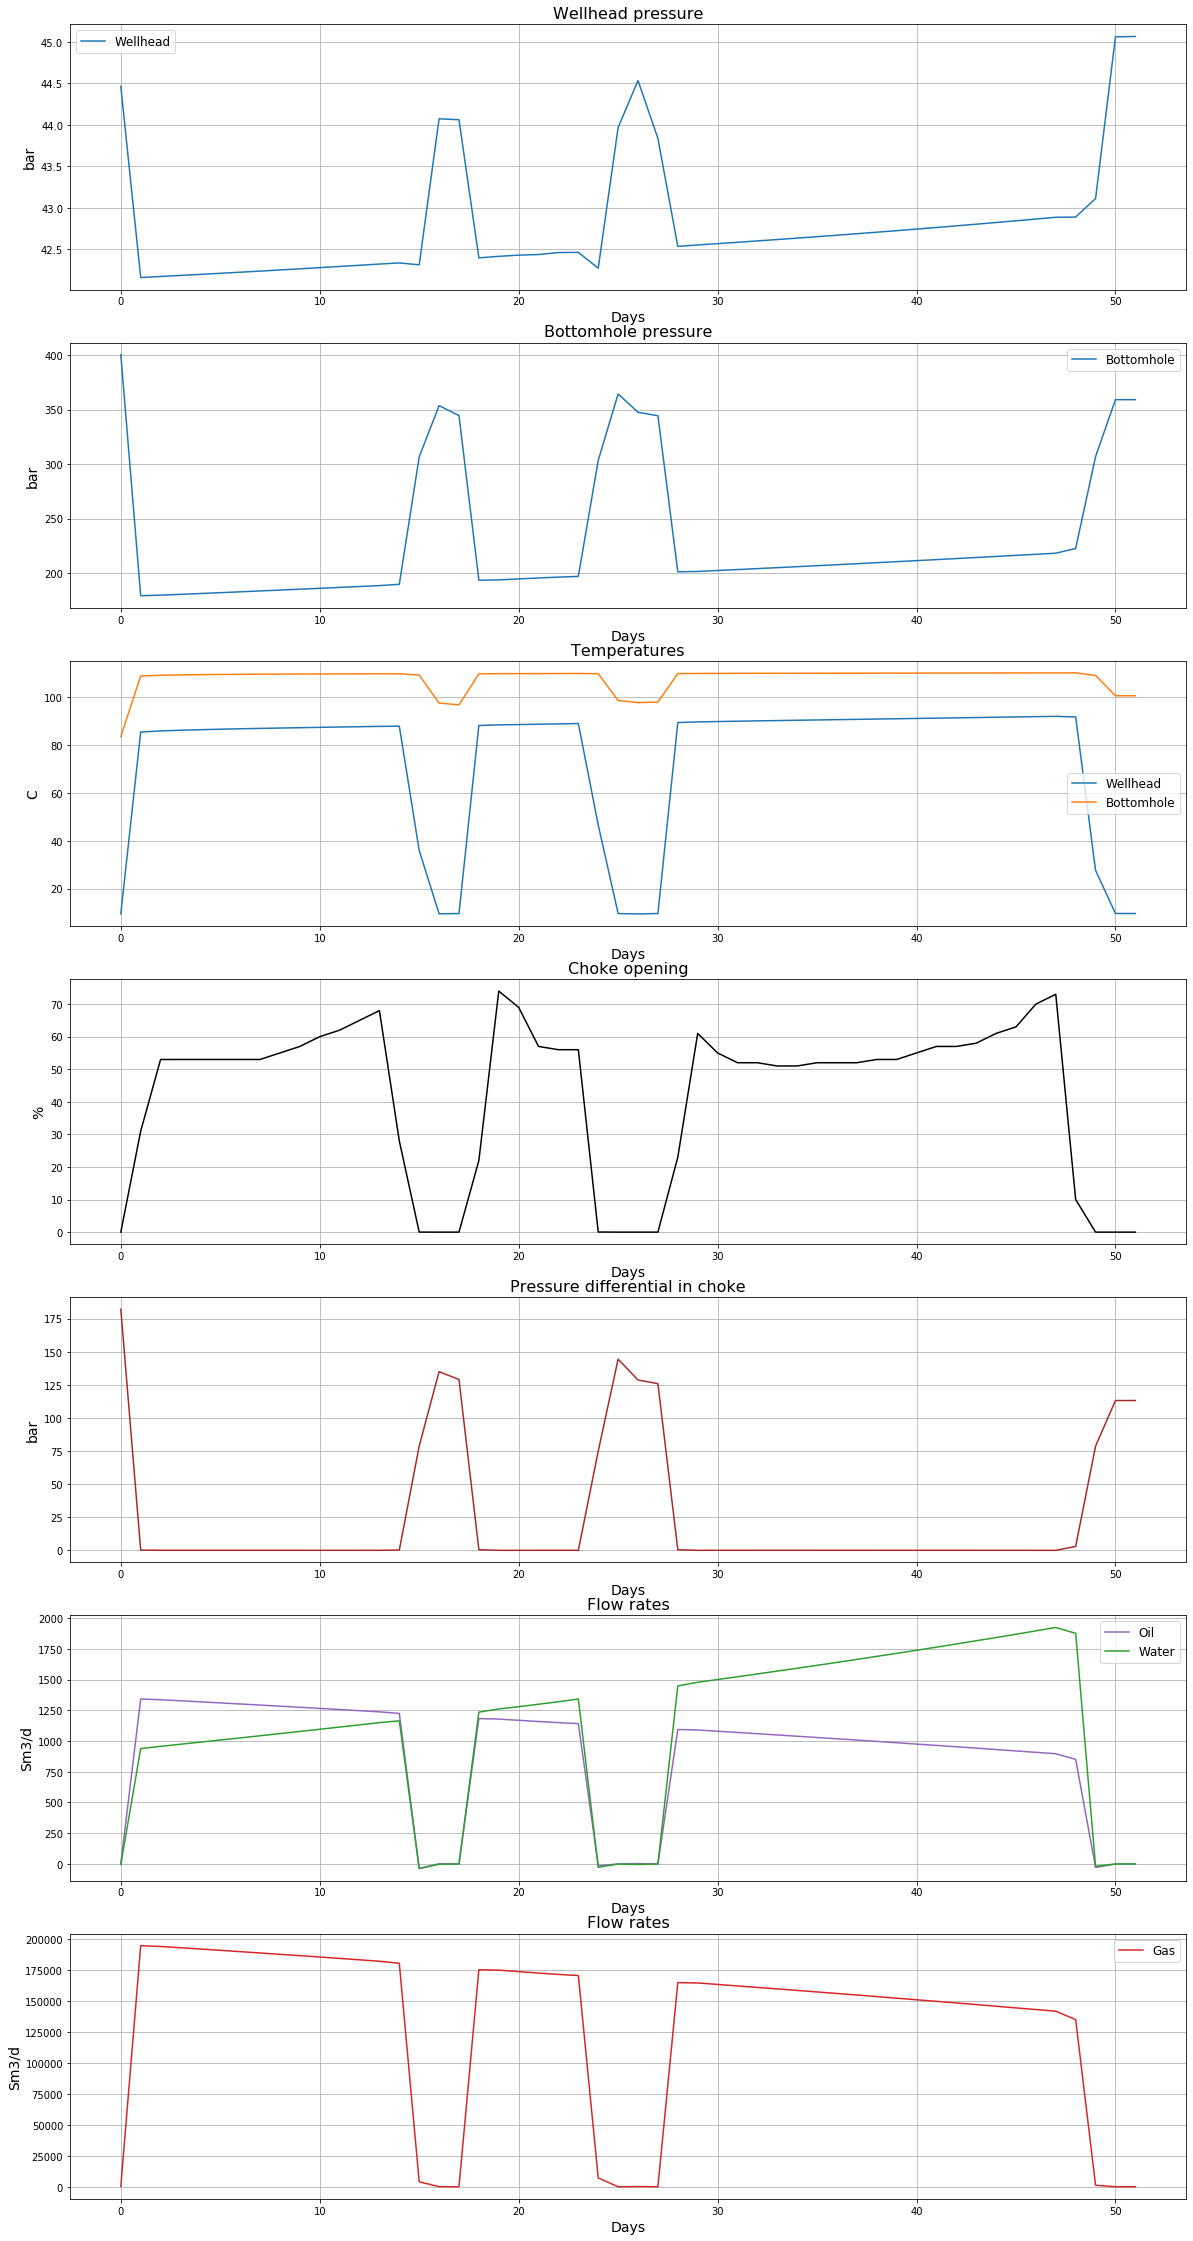

In [8]:
plot_color(df)

In [9]:
outputs = df[['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']]
inputs = df.drop(columns=['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'], axis=1)
inputs.shape, outputs.shape

((52, 7), (52, 3))

In [10]:
train_val_ratio = 7 / 10
n_steps = 10
n_features_in = 6
n_features_out = 3
model_name = 'MLP'

all_len = len(inputs)
train_len = int(np.floor(len(outputs) * train_val_ratio))

n_input = n_steps * n_features_in

In [83]:
# split a multivariate sequence into samples 

raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
true_data = np.hstack((inputs, outputs)) # ins and outs - all

# normalize the data
scaler = MinMaxScaler()
raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
true_data_norm = scaler.transform(true_data)

X, y = split_sequence(raw_seq1_norm, n_steps, n_features_in, n_features_out)
X_all, _ = split_sequence(true_data_norm, n_steps, n_features_in, n_features_out)

X.shape, y.shape, X_all.shape

((26, 10, 6), (26, 3), (42, 10, 6))

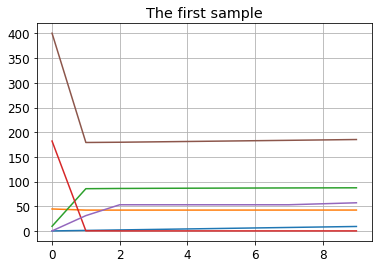

In [84]:
# plot the first sample 

plt.figure(figsize=(6, 4))
plt.plot(raw_seq1[:n_steps, :n_features_in])
plt.title("The first sample")
plt.grid(True)
plt.show();

In [139]:
if model_name == 'MLP':
    lr = 1e-4
    n_epochs = 1300
    
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=n_input))
    # model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(n_features_out))
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    
elif model_name == 'LSTM':
    lr = 1e-4
    n_epochs = 500
    
    n_neurons = 20
    model = Sequential()
    model.add(LSTM(n_neurons, return_sequences=True, activation='relu', input_shape=(n_steps, n_features_in)))
    model.add(Dropout(0.2))
    model.add(LSTM(n_neurons, return_sequences=True, activation='relu'))
    model.add(Dropout(0.2))
    model.add(LSTM(n_neurons, activation='relu'))
    model.add(Dense(n_features_out))
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    
elif model_name == 'TCN': # does not work
    lr = 1e-3
    n_epochs = 500
    
    import tensorflow.keras.layers
    import tensorflow.keras.optimizers

    inputs1 = Input(batch_shape=(5, X.shape[1], n_features_in))
    outputs1 = TCN(nb_filters=1, kernel_size=2, dilations=[1, 2], dropout_rate=0.1, use_skip_connections=True, padding='causal')(inputs1)
    outputs1 = tensorflow.keras.layers.Dense(n_features_out)(outputs1)

    model = Model(inputs=[inputs1], outputs=[outputs1])
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif model_name == "XGB":
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=5, reg_alpha=1))

In [140]:
start_time = time.time()

if model_name == 'TCN':
    model_inf = model.fit(X_reshaped, y, epochs=n_epochs, verbose=1)

elif model_name == 'XGB':
    model.fit(X_reshaped, y)
else:
    model_inf = model.fit(X_reshaped, y, epochs=n_epochs, verbose=1, batch_size=32)

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 26 samples
Epoch 1/500
26/26 [==============================] - 1s 45ms/sample - loss: 1.1867


AbortedError:  Operation received an exception:Status: 3, message: could not create a convolution backward weights descriptor, in file tensorflow/core/kernels/mkl_conv_grad_filter_ops.cc:600
	 [[node Conv2DBackpropFilter_2 (defined at <ipython-input-140-50fe545a277f>:4) ]] [Op:__inference_distributed_function_40310]

Errors may have originated from an input operation.
Input Source operations connected to node Conv2DBackpropFilter_2:
 model_8/tcn_8/residual_block_0/matching_conv1D/conv1d/ExpandDims (defined at C:\Users\Asus\Anaconda3\lib\site-packages\tcn\tcn.py:147)

Function call stack:
distributed_function


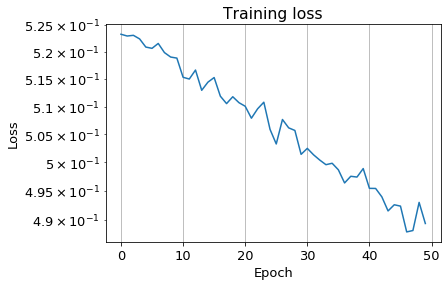

Model name:       LSTM
Training time:    4.501 sec
Train error:      41.281
Test error:       62.064


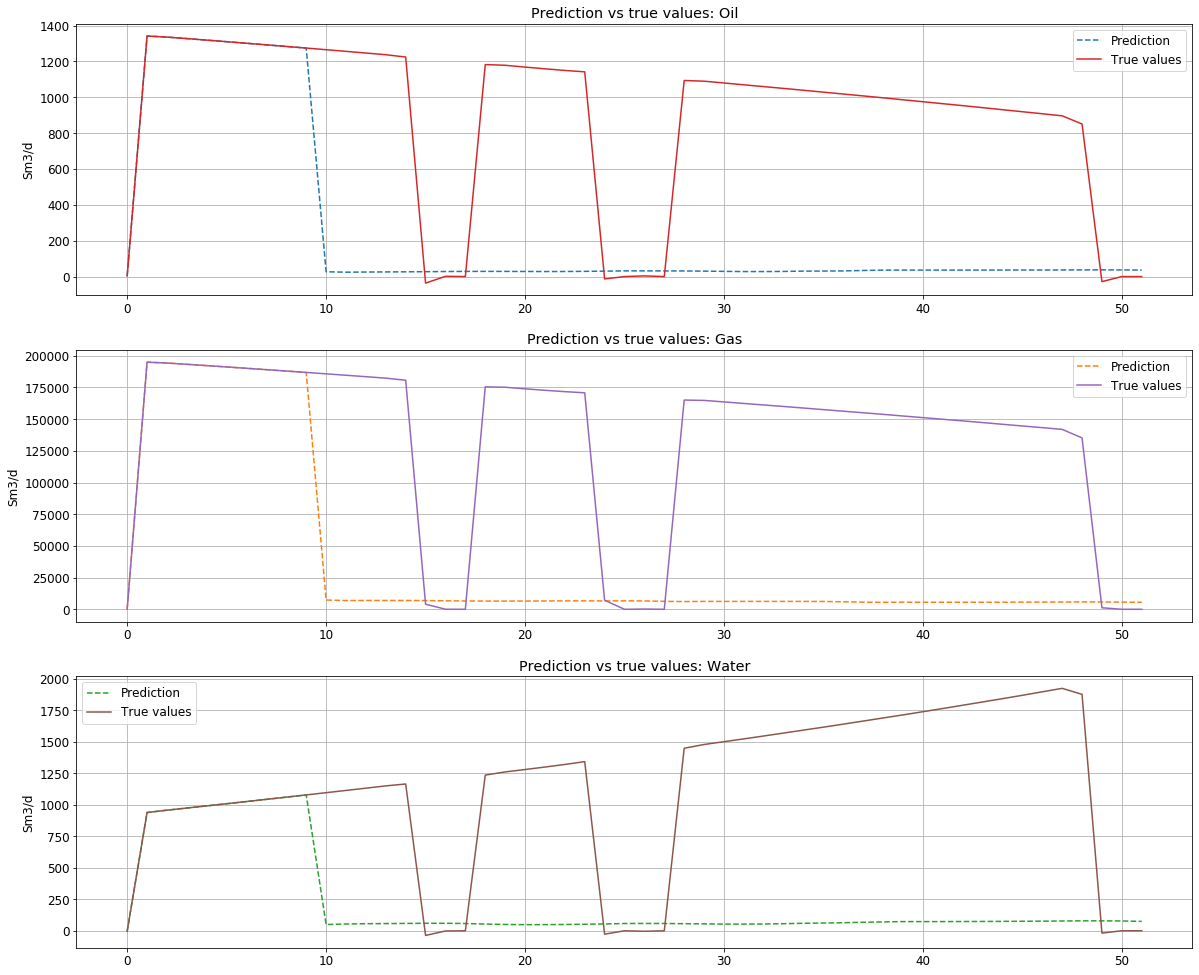

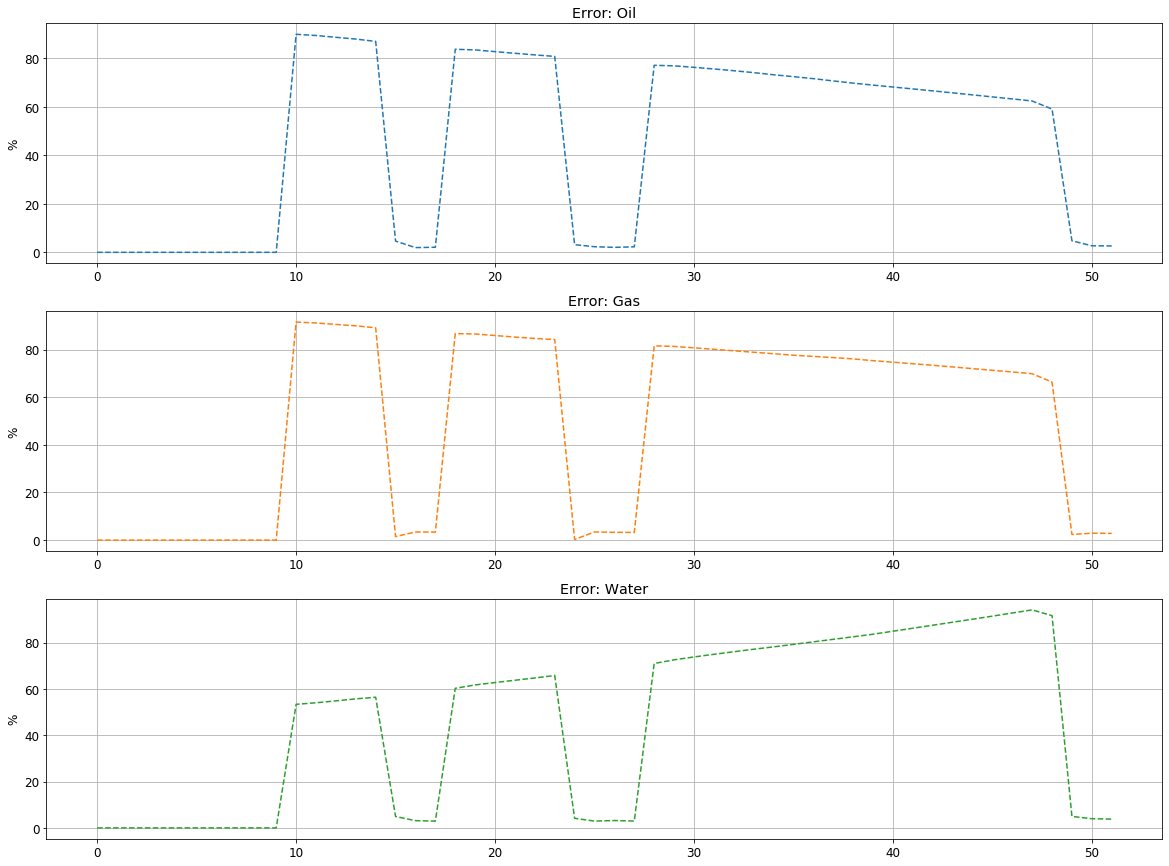

In [129]:
# obtain the model results: make a prediction and calculate an error

y_pred_norm = model.predict(X_all_reshaped)
table_norm = np.hstack((true_data_norm[:, :-n_features_out], np.vstack((raw_seq1_norm[:n_steps, -n_features_out:], y_pred_norm))))
table = scaler.inverse_transform(table_norm) # denormalize all
preds = table[:, -n_features_out:]
errs = error(preds, true_data[:, -n_features_out:]) # calc error between denormalized y_pred and real y

# write the model results to the file

data = {}
data["model_name"] = model_name
data["loss"] = model_inf.history['loss'] if model_name != 'XGB' else ''
data["train_size"] = train_len
data["preds"] = preds.tolist()
data["g_truth"] = true_data[:, -n_features_out:].tolist()
data["errors"] = errs.tolist()
data["training_time"] = delta_time
data["cur_time"] = str(cur_time)

# with open(f'{path}/{model_name}.json', 'w') as file:
#     json.dump(data, file)

if model_name != 'XGB':
    plot_loss(data)
print_results(data)
plot_pred(data)
plot_err(data)

### Save the model

In [130]:
if model_name == 'XGB':
    pickle.dump(model, open(f'{model_name}.hdf', "wb"))
elif model_name == 'TCN':
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{model_name}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{model_name}.h5')
else:
    model.save(f'{model_name}.hdf')

with open('features.json', 'w') as outfile:
    json.dump({'model': model_name,
               'train_val_ratio': train_val_ratio,
               'n_steps': n_steps, 
               'n_features_in': n_features_in,
               'n_features_out': n_features_out,
               'n_epochs': n_epochs,
               'lr': lr
              }, outfile)